# Predictive Analysis using Random Forests Regression
- use Lasso Regression to predict the Bandwidth that a customer will use base on various features from the dataset

## Data Sources
- churn_clean.csv : provided in task prompt by WGU


In [1]:
import sys
print(sys.version)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]


## Imports

In [2]:
# Data handling modules
import pandas as pd
import numpy as np

# Used for Model building
from sklearn.linear_model import Lasso
# Used to Split Data for Validation Purposes
from sklearn.model_selection import train_test_split
# Used to Find Optimal Alpha
from sklearn.model_selection import GridSearchCV
# Used to Validate the model
from sklearn.model_selection import cross_val_score
# Used for Model Evaluation and Calculations
from sklearn.metrics import mean_squared_error as MSE
# Used to add MSE to cross_val_score calculation
from sklearn.metrics import make_scorer

# Used for Data Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Data Preparation

In [3]:
# Import full data set
df = pd.read_csv('churn_clean.csv')

# Drop Demographic Features (except children, age, and income) and survey items
drop_list = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
             'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 
             'Job','Marital', 'Gender','Item1', 'Item2', 'Item3', 'Item4', 'Item5',
             'Item6', 'Item7', 'Item8']

df.drop(drop_list, axis=1, inplace=True)

# Replace "yes" and "no" with 1 and 0 respectively
df.replace('Yes', 1, inplace=True)
df.replace('No', 0, inplace=True)

# Create Dummy Variables for remaining categorical variables
df = pd.get_dummies(df, drop_first=True)

# Save prepared dataset
df.to_csv('prepared_churn.csv', index=False)

# Assign Response variables to y and Predictors to X
y = df['Bandwidth_GB_Year']
X = df.drop('Bandwidth_GB_Year', axis=1)

## Model Building

#### Split the data for training and testing

In [4]:
# Set Seed variable for reproducability
SEED = 830

# Split into 80/20 training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

# Save datasets to CSVs for task prompt D2
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

#### Lasso Regression

In [5]:
# Instantiate the Model
lasso = Lasso() 

# Fit the Model
lasso.fit(X_train, y_train)

# Predict on the test set and training set
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)

# Evaluate the model
mse_lasso_test = MSE(y_test, lasso_pred_test)
mse_lasso_train = MSE(y_train, lasso_pred_train)

print('Training MSE: {:.3f}'.format(mse_lasso_train))
print('Testing MSE: {:.3f}'.format(mse_lasso_test))
print('Lasso R2 Score: {}'.format(lasso.score(X_test, y_test)))

Training MSE: 1297.640
Testing MSE: 1318.763
Lasso R2 Score: 0.9997227633568271


#### Assessing Feature Importance

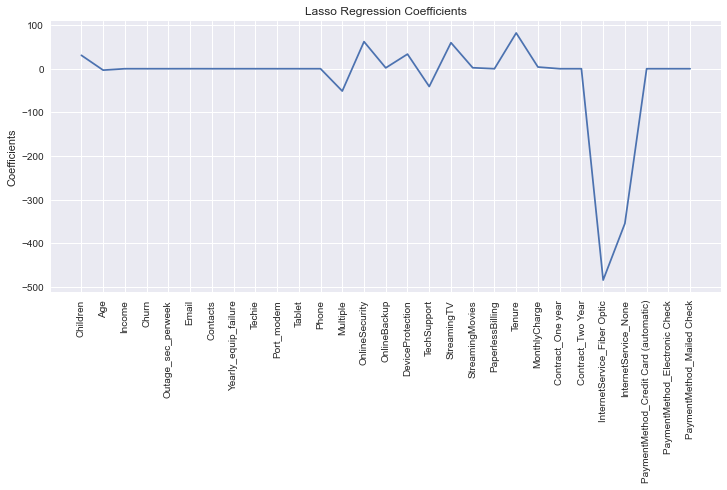

In [6]:
x_labels = X.columns
coef = lasso.coef_

plt.figure(figsize=(12,5))
plt.plot(x_labels, coef)
plt.xticks(x_labels, rotation=90)
plt.ylabel('Coefficients')
plt.title('Lasso Regression Coefficients')
plt.show()

## Tuning the Model

### Use grid search to find optimal alpha value

In [7]:
# Set up range to test for alpha
param_grid = {'alpha':np.arange(0,1,0.01)}

# Instantiate a gridsearch object
grid_lasso = GridSearchCV(estimator=lasso,
                          param_grid=param_grid,
                          cv=5, n_jobs=-1,
                          scoring='neg_mean_squared_error')

# Fit the gridsearch model
grid_lasso.fit(X_train, y_train)

# Print out the best alpha value
print('Best Alpha: {}'.format(grid_lasso.best_params_))

Best Alpha: {'alpha': 0.08}


### Fit model again using found hyperparameters

In [8]:
# Instantiate the Model with new Alpha
lasso2 = Lasso(alpha=0.08)

# Fit the Model
lasso2.fit(X_train, y_train)

# Predict on the test set and training set
lasso2_pred_test = lasso2.predict(X_test)

## Final Model Evaluation

In [9]:
# Calculate Cross Val MSE and Test Set MSE
scorer = make_scorer(MSE)

training_cv = cross_val_score(estimator = lasso2,
                              X=X_train, y=y_train,
                              scoring=scorer,cv=10)

mse_test = MSE(y_test, lasso2_pred_test)
mse_cross_val = np.mean(training_cv)
R2 = lasso2.score(X_test, y_test)

print('Cross Val MSE: {:.3f}'.format(mse_cross_val))
print('Testing MSE: {:.3f}'.format(mse_test))
print('Lasso R2 Score: {}'.format(R2))

print('\nCross Val RMSE: {:.3f}'.format(np.sqrt(mse_cross_val)))
print('Testing RMSE: {:.3f}'.format(np.sqrt(mse_test)))

Cross Val MSE: 1174.957
Testing MSE: 1161.851
Lasso R2 Score: 0.9997557500837867

Cross Val RMSE: 34.278
Testing RMSE: 34.086
